In [1]:
import sys
sys.path.append('/kaggle/input/2023-gw-tools')
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

!pip install --upgrade lalsuite
!pip install timm
from main import *
from utils import *

  Obtaining dependency information for lalsuite from https://files.pythonhosted.org/packages/ad/e6/70c14f7b74c719fbd0212e82f85633e10f06fe2e0220aa3c8eefe98b277a/lalsuite-7.21-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.1/298.1 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 24.8 MB/s eta 0:00:00
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp310-cp310-linux_x86_64.whl size=51620 sha256=dd0846736a76e9d5a08b1b713a26b1aa79f18ac55b4cd7feb1a957443b7f8480
  Stored in directory: /root/.cache/pip/wheels/6d/48/d1/3466977be4e41ba5

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os 
import gc  
import math 
import scipy 
import torch
import timm
import numpy as np 
import pandas as pd 
import torch.nn.functional as F
import matplotlib.pyplot as plt 


from torch import nn 
from torch.utils.data import Dataset, DataLoader


# Device
if torch.backends.mps.is_available() :
    device = torch.device('mps')
elif torch.cuda.is_available() :
    !nvidia-smi
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

Sat Jan  6 04:43:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              25W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Logs
* Version 10 - 频谱数据增强

In [3]:
class CFG(object):
    # 初始化数据生成 class
    nsample_perepoch = 4000  # 每个epoch的样本数
    epochs:int = 60 # 60
    batch_size = 64 #16
    lr:float = 0.004#1e-5
    num_workers = 1
    # 正则化
    normal = True
    
    # 数据增强
    tfms = False
    flip_rate = 0.4 # probability of applying the horizontal flip and vertical flip 
    fre_shift_rate = 1.0 # probability of applying the vertical shift
    time_mask_num = 1 # number of time masking
    freq_mask_num = 2 # number of frequency masking

In [4]:
import torchaudio

transforms_time_mask = nn.Sequential(
                torchaudio.transforms.TimeMasking(time_mask_param=10),
            )

transforms_freq_mask = nn.Sequential(
                torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
            )

# Dataset

In [5]:
class GWDataset(Dataset):
    def __init__(self, fs=8192, T=1, snr=20,
                 detectors=['H1', 'L1'],
                 nsample_perepoch=100,
                 Nnoise=25, mdist='metric',beta=[0.75,0.95],
                 verbose=True, cfg=CFG, tfms=False):
        # 初始化函数，设置各种参数
        if verbose:
            print('GPU available?', torch.cuda.is_available())
        self.fs = fs     # the sampling frequency (Hz)
        self.T = T       # the observation duration (sec)

        safe = 2         # define the safe multiplication scale for the desired time length
        self.T *= safe

        self.detectors = detectors
        self.snr = snr
        
        self.normal = cfg.normal
        self.tfms = tfms
        self.flip_rate = cfg.flip_rate
        self.fre_shift_rate = cfg.fre_shift_rate
        self.time_mask_num = cfg.time_mask_num
        self.freq_mask_num = cfg.freq_mask_num
        self.generate(nsample_perepoch, Nnoise, mdist, beta)  # pre-generate sampels

    def generate(self, Nblock, Nnoise=25, mdist='metric',beta=[0.75,0.95]):
        # 生成数据的函数
        # Nnoise: # the number of noise realisations per signal
        # Nblock: # the number of training samples per output file
        # mdist:  # mass distribution (astro,gh,metric)

        ts, par = sim_data(self.fs, self.T, self.snr, self.detectors, Nnoise, size=Nblock, mdist=mdist,
                           beta=beta, verbose=False)
        self.strains = np.expand_dims(ts[0], 1)   # (nsample, 1, len(det), fs*T)
        self.labels = ts[1]

    def __len__(self):
        # 返回数据的长度
        return len(self.strains)

    def __getitem__(self, idx):
        # 获取数据的函数
        img = np.reshape(self.strains[idx], (2, 128, -1))
        
        if self.tfms:
            if np.random.rand() <= self.flip_rate: # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= self.flip_rate: # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= self.fre_shift_rate: # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            
            img = torch.from_numpy(img)

            for _ in range(self.time_mask_num): # tima masking
                img = transforms_time_mask(img)
            for _ in range(self.freq_mask_num): # frequency masking
                img = transforms_freq_mask(img)
                img = img.type(torch.float32)
        
        else:
            img = torch.from_numpy(img)
            #img = img.type(torch.float32)
        if self.normal :
            img = (img - img.mean()) / (img.std()+1e-5)
            
        y = self.labels[idx]
        return img, y

# Model

In [6]:
class LargeKernel_debias(nn.Conv2d):
    def forward(self, input: torch.Tensor):
        
        #print(f'输入进大内核的数据形状:{input.shape}')
        finput = input.flatten(0, 1)[:, None]
        target = abs(self.weight)
        target = target / target.sum((-1, -2), True)
        joined_kernel = torch.cat([self.weight, target], 0)
        reals = target.new_zeros(
            [1, 1] + [s + p * 2 for p, s in zip(self.padding, input.shape[-2:])]
        )
        reals[
            [slice(None)] * 2 + [slice(p, -p) if p != 0 else slice(None) for p in self.padding]
        ].fill_(1)
        
        #print(f'device{finput.device}')
        output, power = torch.nn.functional.conv2d(
            finput, joined_kernel, padding=self.padding
        ).chunk(2, 1)
        ratio = torch.div(*torch.nn.functional.conv2d(reals, joined_kernel).chunk(2, 1))
        
        power_ = torch.mul(power, ratio)
        output = torch.sub(output,power_)
        out = output.unflatten(0, input.shape[:2]).flatten(1, 2)
        #print(f'大内核的输出形状:{out.shape}')
        #print(f'大内核的内容:{out}')
        return out

In [7]:
class Model(nn.Module):
    def __init__(self, name, *, pretrained=False):
        """
        name (str): timm model name, e.g. tf_efficientnet_b2_ns
        """
        super(Model, self).__init__()

        # Use timm
        model = timm.create_model(name, pretrained=pretrained, in_chans=32)
        
        # torch.Size([16, 1, 31, 255])
        model.conv_stem = nn.Sequential(
            nn.Identity(),
            nn.AvgPool2d((1, 9), (1, 8), (0, 4), count_include_pad=False),
            LargeKernel_debias(1, 16, [31, 255], 1, [31//2, 255//2], 1, 1, False),
            model.conv_stem,
        )
        
        clsf = model.default_cfg['classifier']
        n_features = model._modules[clsf].in_features
        model._modules[clsf] = nn.Identity()
        self.model = model
        
        self.fc = nn.Linear(n_features, 2)
        
        

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

# Train

In [8]:
train_dataset = GWDataset(snr=20, nsample_perepoch=CFG.nsample_perepoch, tfms=CFG.tfms)
test_dataset = GWDataset(snr=20, nsample_perepoch=CFG.nsample_perepoch)
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=False)

GPU available? True
GPU available? True


loss 0.0009, train acc 0.984, test acc 0.985
421.7 examples/sec on cuda


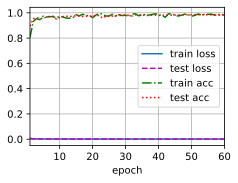

In [9]:
model = Model(name='tf_efficientnet_b5_ns', pretrained=True)
model.to(device)
train_loss_history = []
checkpoint_dir = './'

train(net=model,
      lr=CFG.lr,
      nsample_perepoch=CFG.nsample_perepoch,
      epoch=0, #从0 开始一直到达total_epochs结束
      total_epochs=CFG.epochs,
      dataset_train=train_dataset,
      data_loader=train_loader,
      train_loss_history=train_loss_history,
      checkpoint_dir=checkpoint_dir,
      test_iter=test_loader,
      device=device)

# Infer

In [10]:
# 加载必要的库
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal  # https://git.ligo.org/lscsoft/lalsuite/-/issues/300
from main import *
from utils import *
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import _pickle as pickle


def evaluate_submissoin_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的预测结果"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 获取设备信息
    softmax = nn.Softmax(dim=-1)  # 定义softmax函数，dim=-1表示在最后一个维度上进行softmax运算
    y_hat_list = []  # 初始化预测结果列表
    with torch.no_grad():  # 不进行梯度计算
        for X in tqdm(data_iter):  # 遍历数据集
            #print(X.shape)
            X = X.view(X.shape[0], 2, 128, -1)
            X = X.to(device).to(torch.float)  # 将数据转移到设备上并转换为浮点型
            y_hat = net(X)  # 使用模型进行预测
            preds = softmax(y_hat).cpu().numpy()[:,1].tolist()  # 使用softmax函数处理预测结果，并转换为列表
            y_hat_list.extend(preds)  # 将预测结果添加到预测结果列表
    return y_hat_list

In [11]:
test_dataset = np.load('/kaggle/input/2023-gwdata-bootcamp/test.npy')
test_dataset.shape

(1200, 1, 2, 16384)

In [12]:
data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
results = evaluate_submissoin_gpu(model, data_loader, device)
len(results)

100%|██████████| 38/38 [00:01<00:00, 21.74it/s]


1200

In [14]:
import pandas as pd
pd.DataFrame({'id': range(len(results)),
              'target': results}, index=None).to_csv('submission.csv', index=False)

<Axes: ylabel='Frequency'>

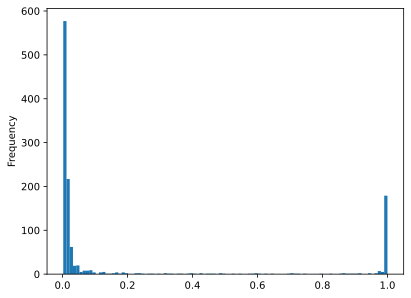

In [15]:
a = pd.read_csv('/kaggle/working/submission.csv')
a.target.plot.hist(bins=100)